In [1]:
import pandas as pd
import numpy as np
import json

%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, confusion_matrix,
                             precision_recall_curve)

In [2]:
data = pd.read_csv('./breast-cancer-data.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
mean radius                569 non-null float64
mean texture               569 non-null float64
mean perimeter             569 non-null float64
mean area                  569 non-null float64
mean smoothness            569 non-null float64
mean compactness           569 non-null float64
mean concavity             569 non-null float64
mean concave points        569 non-null float64
mean symmetry              569 non-null float64
mean fractal dimension     569 non-null float64
radius error               569 non-null float64
texture error              569 non-null float64
perimeter error            569 non-null float64
area error                 569 non-null float64
smoothness error           569 non-null float64
compactness error          569 non-null float64
concavity error            569 non-null float64
concave points error       569 non-null float64
symmetry error             569 

## Processing training dataset

In [3]:
X = data.drop(columns=['diagnosis'])
y = data['diagnosis'].map({'malignant': 1, 'benign': 0}.get).values

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=11)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(455, 30)
(455,)
(114, 30)
(114,)


## Modelling

In [5]:
meta_gbc = GradientBoostingClassifier()

param_dist = {
    'n_estimators': list(range(10, 210, 10)),
    'criterion': ['mae', 'mse'],
    'max_features': ['sqrt', 'log2', 0.25, 0.3, 0.5, 0.8, None],
    'max_depth': list(range(1, 10)),
    'min_samples_leaf': list(range(1, 10))
}

In [6]:
rand_search_params = {
    'param_distributions': param_dist,
    'scoring': 'accuracy',
    'n_iter': 100,
    'cv': 5,
    'return_train_score': True,
    'n_jobs': -1,
    'random_state': 11
}
random_search = RandomizedSearchCV(meta_gbc, **rand_search_params)
random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=GradientBoostingClassifier(criterion='friedman_mse',
                                                        init=None,
                                                        learning_rate=0.1,
                                                        loss='deviance',
                                                        max_depth=3,
                                                        max_features=None,
                                                        max_leaf_nodes=None,
                                                        min_impurity_decrease=0.0,
                                                        min_impurity_split=None,
                                                        min_samples_leaf=1,
                                                        min_samples_split=2,
                                                        min_weight_fraction_leaf=0.0,
                     

In [7]:
idx = np.argmax(random_search.cv_results_['mean_test_score'])
final_params = random_search.cv_results_['params'][idx]
final_params

{'n_estimators': 170,
 'min_samples_leaf': 6,
 'max_features': 0.3,
 'max_depth': 4,
 'criterion': 'mse'}

In [8]:
train_X, val_X, train_y, val_y = train_test_split(X_train, y_train, test_size=0.15, random_state=11)
train_X.shape, train_y.shape, val_X.shape, val_y.shape

((386, 30), (386,), (69, 30), (69,))

In [9]:
gbc = GradientBoostingClassifier(**final_params)
gbc.fit(train_X, train_y)

preds_train = gbc.predict(train_X)
preds_val = gbc.predict(val_X)
pred_probs_val = np.array([each[1] for each in gbc.predict_proba(val_X)])

In [10]:
print('train accuracy_score = {}'.format(accuracy_score(y_true=train_y, y_pred=preds_train)))
print('validation accuracy_score = {}'.format(accuracy_score(y_true=val_y, y_pred=preds_val)))

print('confusion_matrix: \n{}'.format(confusion_matrix(y_true=val_y, y_pred=preds_val)))
print('precision_score = {}'.format(precision_score(y_true=val_y, y_pred=preds_val)))
print('recall_score = {}'.format(recall_score(y_true=val_y, y_pred=preds_val)))

train accuracy_score = 1.0
validation accuracy_score = 0.9710144927536232
confusion_matrix: 
[[45  0]
 [ 2 22]]
precision_score = 1.0
recall_score = 0.9166666666666666


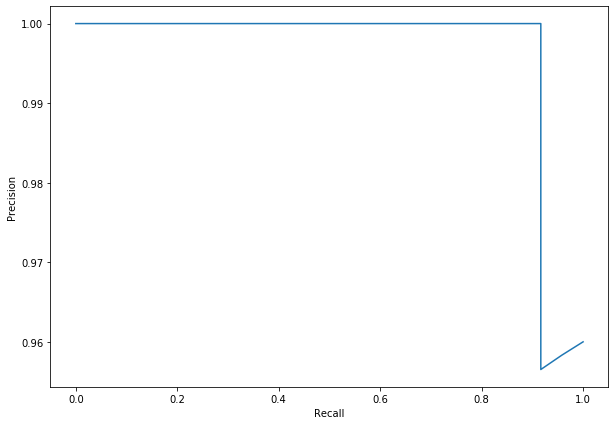

In [11]:
plt.figure(figsize=(10,7)) 
 
precision, recall, thresholds = precision_recall_curve(val_y, pred_probs_val) 
plt.plot(recall, precision) 
plt.xlabel('Recall') 
plt.ylabel('Precision') 
plt.show()

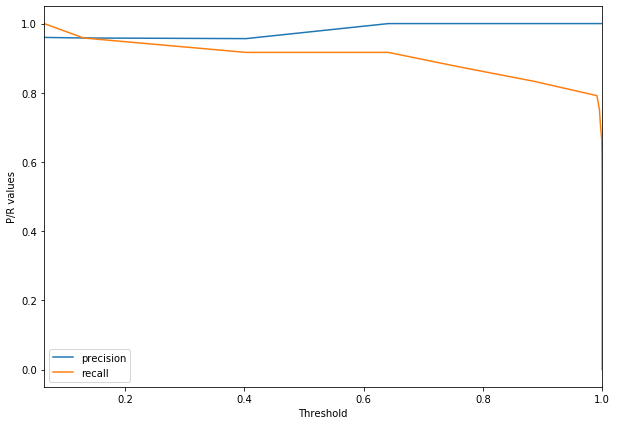

In [12]:
# Plot the variation in precision and recall with increasing threshold values. 
PR_variation_df = pd.DataFrame({'precision': precision, 'recall': recall}, index=list(thresholds)+[1]) 
 
PR_variation_df.plot(figsize=(10,7)) 
plt.xlabel('Threshold') 
plt.ylabel('P/R values') 
plt.show() 

In [13]:
final_threshold = 0.05

## Predicting on test dataset

In [14]:
pred_probs_test = np.array([each[1] for each in gbc.predict_proba(X_test)])
preds_test = (pred_probs_test > final_threshold).astype(int)

In [15]:
with open('final_predictions.csv', 'w') as f:
    f.writelines([str(val)+'\n' for val in preds_test])

In [16]:
preds_test

array([1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0,
       0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1,
       0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0,
       0, 1, 0, 1])